# Animal training

In [ ]:
!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list

!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -

!apt -qq update

!apt -qq install gcsfuse

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2537  100  2537    0     0  43741      0 --:--:-- --:--:-- --:--:-- 44508
OK
62 packages can be upgraded. Run 'apt list --upgradable' to see them.
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 newly installed, 0 to remove and 62 not upgraded.
Need to get 12.5 MB of archives.
After this operation, 28.5 MB of additional disk space will be used.
Selecting previously unselected package gcsfuse.
(Reading database ... 155222 files and directories currently installed.)
Preparing to unpack .../gcsfuse_0.38.0_amd64.deb ...
Unpacking gcsfuse (0.38.0) ...
Setting up gcsfuse (0.38.0) ...


In [ ]:
from google.colab import auth

auth.authenticate_user()

!mkdir cl_images

!gcsfuse --implicit-dirs bigdata_assignment1 cl_images


2021/12/12 22:54:05.876314 Start gcsfuse/0.38.0 (Go version go1.17.3) for app "" using mount point: /content/cl_images
2021/12/12 22:54:05.890327 Opening GCS connection...
2021/12/12 22:54:06.236254 Mounting file system "bigdata_assignment1"...
2021/12/12 22:54:06.265689 File system has been successfully mounted.


## Import images

Attaching the bucket is done, start importing the 
images. But first start fastAI.

In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

from fastbook import *

     |████████████████████████████████| 720 kB 5.1 MB/s 
     |████████████████████████████████| 189 kB 37.8 MB/s 
     |████████████████████████████████| 1.2 MB 29.8 MB/s 
     |████████████████████████████████| 46 kB 4.0 MB/s 
     |████████████████████████████████| 56 kB 3.9 MB/s 
     |████████████████████████████████| 51 kB 283 kB/s 


Get an overfiew of the categories

In [ ]:
!ls /content/cl_images/data

dog  eagle  horse  rhino  tiger


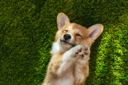

In [ ]:
path = '/content/cl_images/data'
im = Image.open(path + '/dog/dog1.jpg')
im.to_thumb(128,128)

To be more effective, we create filenames.

In [ ]:
from fastai.vision.all import *
filenames = get_image_files(path)
filenames

(#1499) [Path('/content/cl_images/data/dog/dog1.jpg'),Path('/content/cl_images/data/dog/dog10.jpg'),Path('/content/cl_images/data/dog/dog100.jpg'),Path('/content/cl_images/data/dog/dog101.jpg'),Path('/content/cl_images/data/dog/dog102.jpg'),Path('/content/cl_images/data/dog/dog103.jpg'),Path('/content/cl_images/data/dog/dog104.jpg'),Path('/content/cl_images/data/dog/dog105.jpg'),Path('/content/cl_images/data/dog/dog106.jpg'),Path('/content/cl_images/data/dog/dog107.jpg')...]

Here we test and see that everything is in order.

In [ ]:
failed = verify_images(filenames)
failed

In [ ]:
animals = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [ ]:
dls = animals.dataloaders(path)

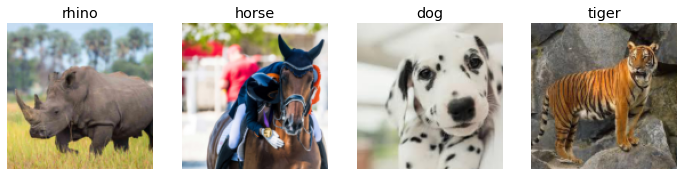

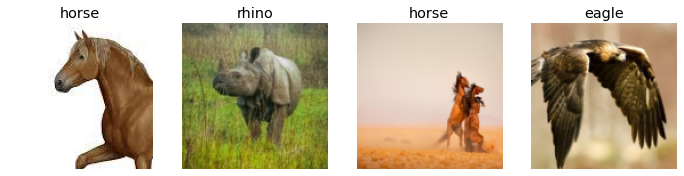

In [ ]:
dls.train.show_batch(max_n=4, nrows=1)
dls.valid.show_batch(max_n=4, nrows=1)

In [ ]:
firstModel = cnn_learner(dls, resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
firstModel.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time


KeyboardInterrupt: ignored

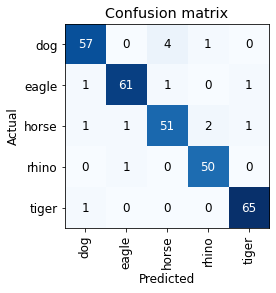

In [ ]:
interp = ClassificationInterpretation.from_learner(firstModel)
interp.plot_confusion_matrix()

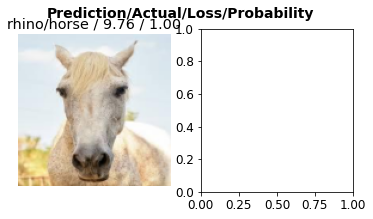

In [ ]:
interp.plot_top_losses(2, nrows=1)

In [ ]:
# saving our model, by default in a folder called 'models'.
firstModel.save('first_model')
#creating an serialized pickle object of our model, the export.pkl file
firstModel.export()

In [ ]:
dls = animals.dataloaders(path)

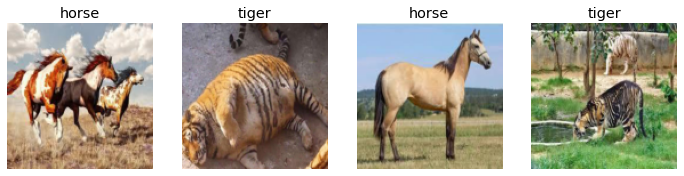

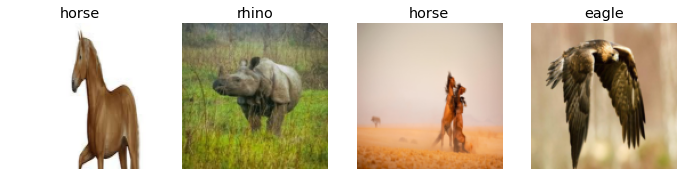

In [ ]:
dls.train.show_batch(max_n=4, nrows=1)
dls.valid.show_batch(max_n=4, nrows=1)

Alexnet

In [ ]:
alex_model = cnn_learner(dls, alexnet, metrics=error_rate)
alex_model.fine_tune(4)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.566442,0.486344,0.147157,00:32


epoch,train_loss,valid_loss,error_rate,time
0,0.459773,0.397967,0.120401,00:44
1,0.348074,0.352980,0.100334,00:32


In [ ]:
interp2 = ClassificationInterpretation.from_learner(alex_model)
interp2.plot_confusion_matrix()

VGG

In [ ]:
vgg16_model = cnn_learner(dls, vgg16_bn, metrics=error_rate)
vgg16_model.fine_tune(4)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.372116,0.208029,0.073579,04:18


epoch,train_loss,valid_loss,error_rate,time
0,0.212423,0.151370,0.056856,04:05


In [ ]:
interp3 = ClassificationInterpretation.from_learner(vgg16_model)
interp3.plot_confusion_matrix()

Comparing all of the different models, we learn that resnet is the best one, because it has the lowest error rate? We decide to further experiment with fit_one_cycle to start training at lower learnign rate, perhaps we can get better results?

In [ ]:
resnet152_model = cnn_learner(dls, resnet152, metrics=error_rate)
resnet152_model.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.805110,0.130816,0.046823,04:25


epoch,train_loss,valid_loss,error_rate,time
0,0.144134,0.206021,0.056856,04:02
1,0.136366,0.304443,0.060201,03:57
2,0.134770,0.133952,0.043478,04:03
3,0.103728,0.105542,0.033445,03:58


In [ ]:
interp4 = ClassificationInterpretation.from_learner(resnet152_model)
interp4.plot_confusion_matrix()

In [ ]:
resnet50_just_right = cnn_learner(dls, resnet50, metrics=error_rate)


In [ ]:
resnet50_just_right.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,0.666577,0.232668,0.040134,04:04
1,0.375703,0.226774,0.056856,03:55
2,0.254142,0.202689,0.050167,03:59


In [ ]:
resnet50_just_right.unfreeze()

SuggestedLRs(valley=7.585775892948732e-05)

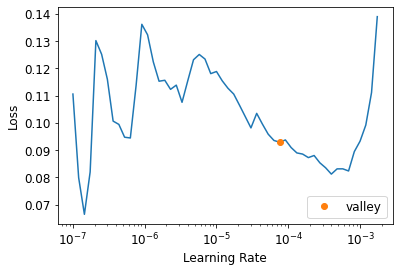

In [ ]:
resnet50_just_right.lr_find()

ASK TEACHERS ABOUT THIS.. Why does it have a higher error rate with the Perfect learning rate(?)

In [ ]:
resnet50_just_right.fine_tune(4, base_lr=10e-05)

epoch,train_loss,valid_loss,error_rate,time
0,0.072855,0.187362,0.050167,04:06


epoch,train_loss,valid_loss,error_rate,time
0,0.097251,0.185996,0.053512,04:07
1,0.094135,0.180253,0.043478,04:24
2,0.084355,0.168005,0.043478,04:11
3,0.070975,0.184309,0.053512,03:59
